In [26]:
#Importing important libraries for data analysis
from statistics import mean
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
# import statsmodels.api as sm
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

In [27]:
#Creation of new dataframes to store refined values of datasets
new_df = pd.DataFrame()
test_new_df = pd.DataFrame()


In [28]:
#Creation of pandas dataframes for train.csv and test.csv
#sorted by store numbers & family
train_df = pd.read_csv("train.csv").sort_values(["store_nbr", "family"])
test_df = pd.read_csv("test.csv").sort_values(["store_nbr", "family"])

In [29]:
#function for adf test
def adfuller_test(sales):
    result = adfuller(sales)
    labels =  ['ADF test statistic', 'p value', '#Lags used','No. of observations used']
    for value, label in zip(result,labels):
        print(label+':'+str(value))
    if result[1] <= 0.05 :
        print('Strong evidence against null hypothesis, data is stationary')
    else:
        print('Weak evidence against null hypothesis, data is non-stationary')

In [30]:
#dataset for EDA 
pdq_train = train_df[['date','sales']].set_index('date')[:50000]

In [31]:
#results for ADF test
adfuller_test(pdq_train.sales)

ADF test statistic:-4.107645232197649
p value:0.0009407231501629114
#Lags used:57
No. of observations used:49942
Strong evidence against null hypothesis, data is stationary


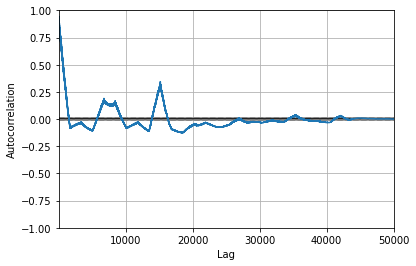

In [32]:
#auto correlation plots for training dataset
autocorrelation_plot(pdq_train)
plt.show()

In [33]:
#Replacement of slashes in family names to save the models properly
train_df['family'] = train_df['family'].str.replace("/", " ")
train_df['family'] = train_df['family'].str.replace(",", " ")

In [34]:
#An empty dictionary created for storing lists as values
unique = {} 

#defines unique store numbers in the train data
unique['strnbr_unique'] = train_df["store_nbr"].dropna().unique()

#defines unique families of products in the train data
unique['family_unique'] = train_df["family"].dropna().unique()

rmsle_list = []

In [35]:
#Function showing calculation of Root Mean Square Logarithmic Errror
def rmsle(y_true, y_pred):
    #Ensuring no negative values go through
    y_pred[y_pred<0]=0.0

    #Taking square root of mean squared log error 
    metric = np.sqrt(mean_squared_log_error(y_true, y_pred))

    #rounding up the values till 4 decimal places
    return round(metric, 4)

In [36]:
#Creating valid dataset for each unique family
def dataset_creation(fam, df):
    temp_df = df[(df["family"] == fam)]

    #making a shift of 1 for previous day sales
    temp_df["prev_sales"] = temp_df["sales"].shift(1)
    
    #filtering out all the 0 values of sales
    temp_df['prev_sales'] = temp_df['prev_sales'].fillna(0.0)

    #sorting data by store number and dates
    temp_df = temp_df.sort_values(['store_nbr','date'])

    #setting date as index of dataframe
    new_df_train = temp_df[['date','sales']].set_index('date')
    
    return new_df_train 

In [37]:
#Function to reuse the saved models as files
def model_reuse(model_name):
    with open(model_name, 'rb') as file:  
        Pickled_Model = pickle.load(file)
    return Pickled_Model

In [38]:
#Function to forecast the predicted values as testing
def testing(model, test):
    #forecasting the data with step size of length of test data
    yhat = (model.forecast(steps = len(test))[0])
    
    #y_true is the sales values of testing set
    y = test['sales'].to_numpy()   #RMSLE needs values in array format
    
    #Calculation of RSMSLE by using rmsle function
    value = rmsle(y, yhat)

    #Plotting all the predictions
    plt.figure(figsize=(15,8))
    ax1 = plt.subplot(211)
    fig = model.plot_predict(65000,65200,ax=ax1)
    fig.show()
    
    return value
    

In [39]:
def train_model(fam, train_df):
    new_df_train = dataset_creation(fam, train_df)
    
    #creating train and test split sets, taking 80 percent of data for train
    train = new_df_train[:int(len(new_df_train) * 0.8)]
    test = new_df_train[int(len(new_df_train) * 0.8):]
    
    #replacing null values of train
    train = train.fillna(0.0)

    #training the model ofr (1,1,0) order
    model = ARIMA(train,order = (1,1,0))
    
    #fitting the model
    model_fitting = model.fit()
    
    #deriving the rmsle values
    rmsle_value=testing(model_fitting, test)

    #saving the model
    model_fitting.save('modelTrain_' + fam + '.h5')
    return rmsle_value

family: AUTOMOTIVE 1.5495
family: BABY CARE 0.1024
family: BEAUTY 1.4036
family: BEVERAGES 3.0953
family: BOOKS 0.3133
family: BREAD BAKERY 2.6543
family: CELEBRATION 2.3185
family: CLEANING 2.8931
family: DAIRY 3.1096
family: DELI 2.4418
family: EGGS 2.7834
family: FROZEN FOODS 2.7714
family: GROCERY I 3.7484
family: GROCERY II 2.1871
family: HARDWARE 0.6977
family: HOME AND KITCHEN I 3.0004
family: HOME AND KITCHEN II 2.8701
family: HOME APPLIANCES 1.1016
family: HOME CARE 4.6157
family: LADIESWEAR 2.0857
family: LAWN AND GARDEN 1.2929
family: LINGERIE 1.5856
family: LIQUOR WINE BEER 2.6417
family: MAGAZINES 1.615
family: MEATS 2.7271
family: PERSONAL CARE 2.3755
family: PET SUPPLIES 2.0126
family: PLAYERS AND ELECTRONICS 2.253
family: POULTRY 3.0298
family: PREPARED FOODS 2.592
family: PRODUCE 4.3135
family: SCHOOL AND OFFICE SUPPLIES 1.6099
family: SEAFOOD 2.524


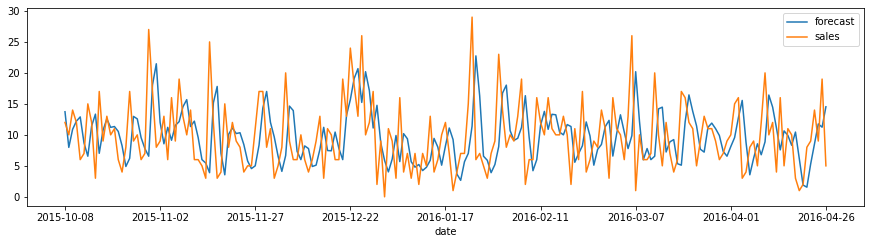

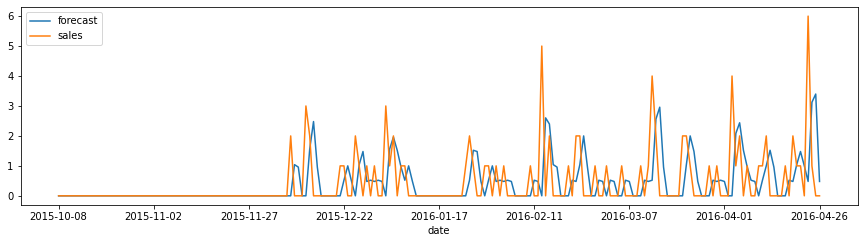

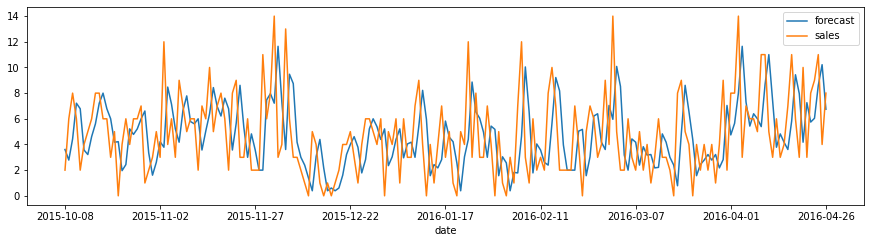

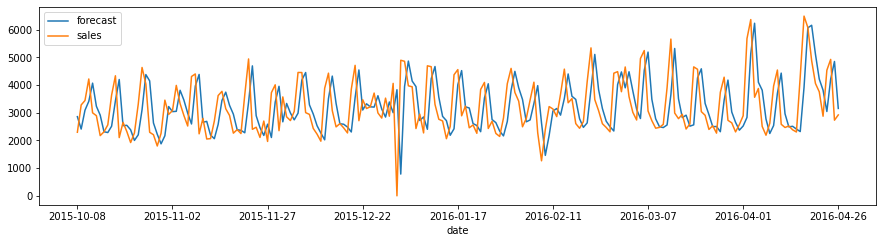

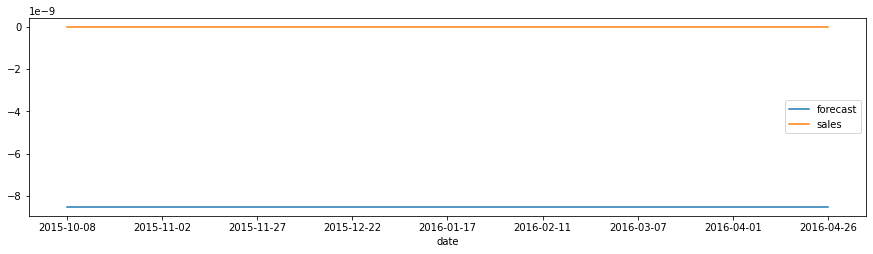

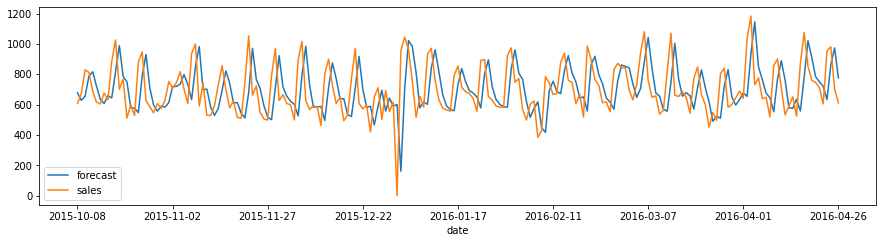

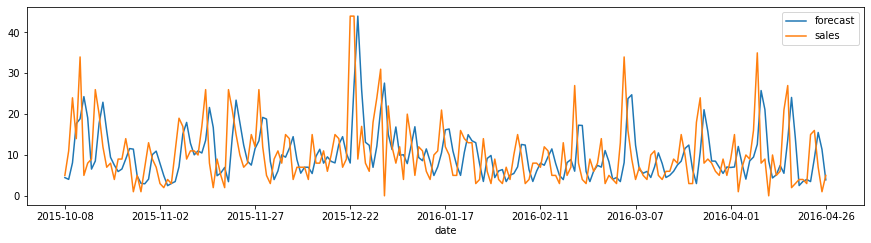

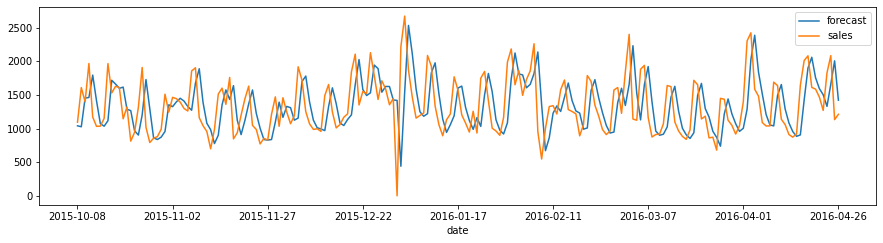

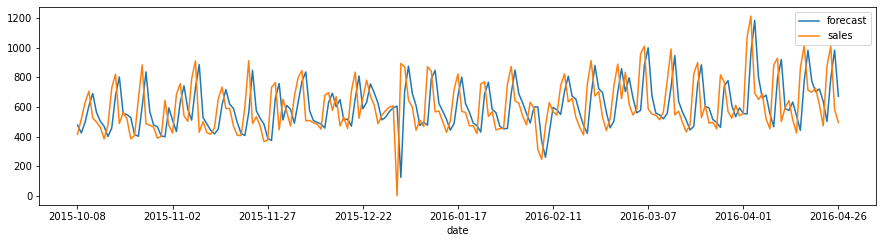

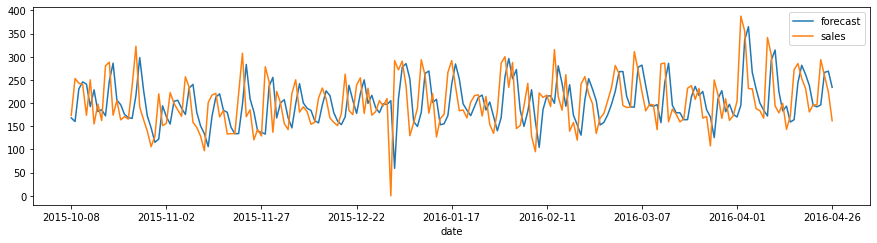

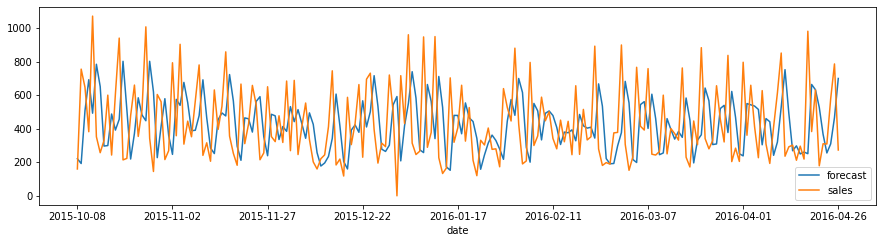

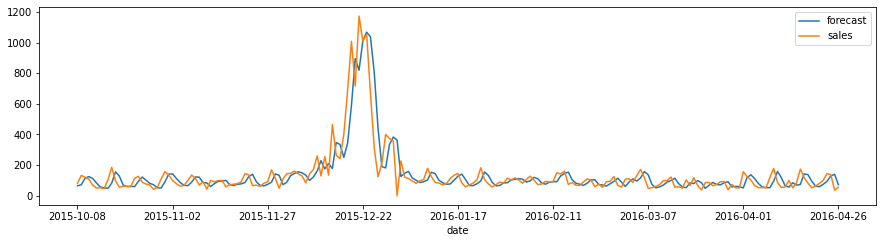

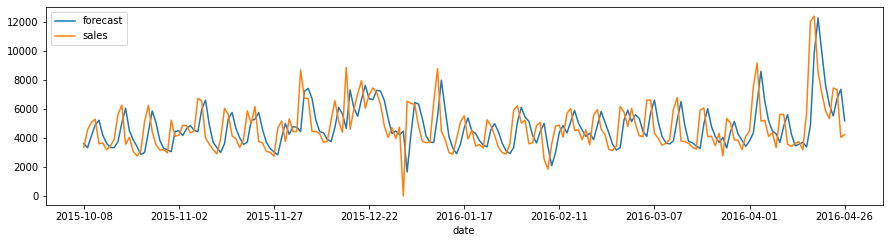

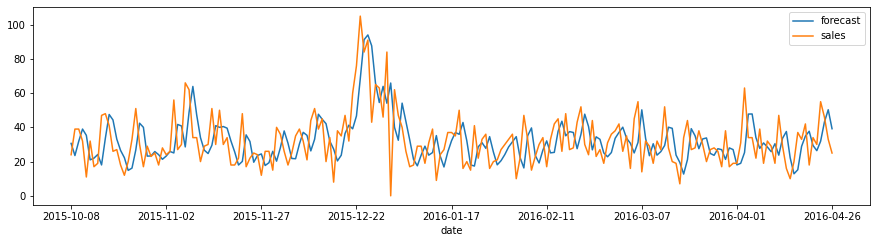

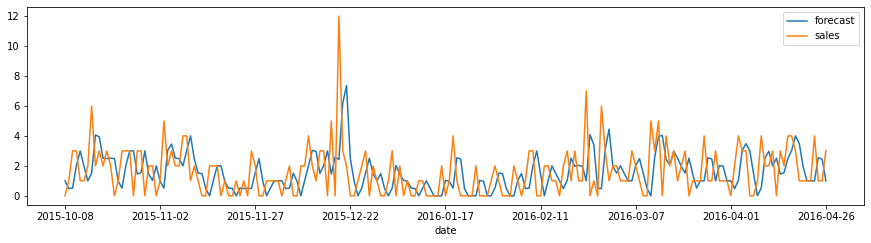

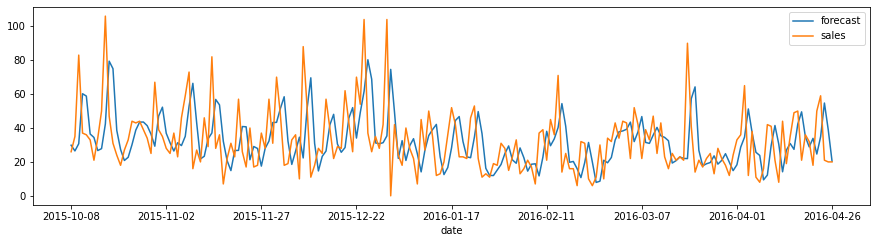

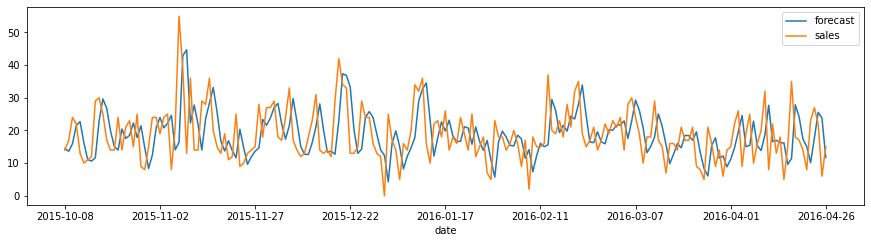

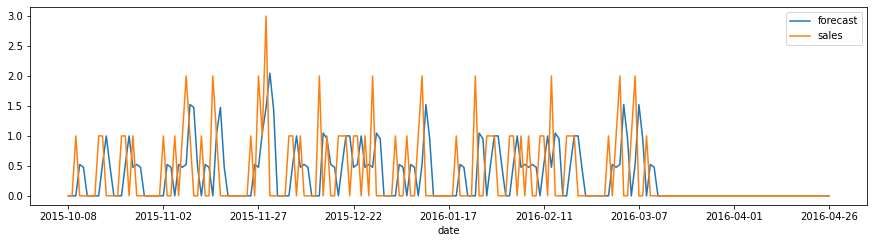

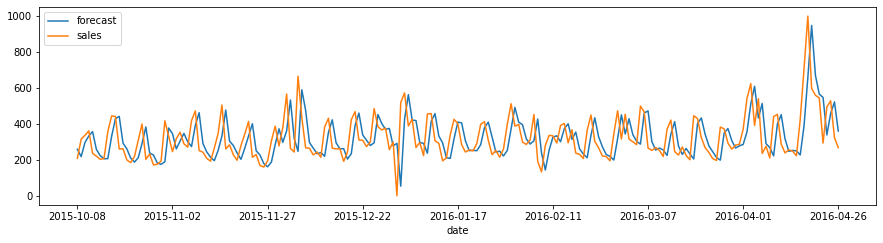

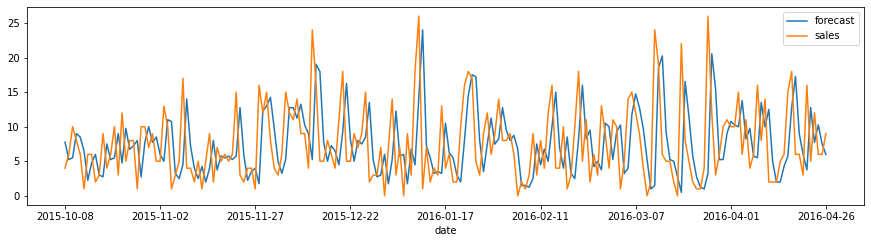

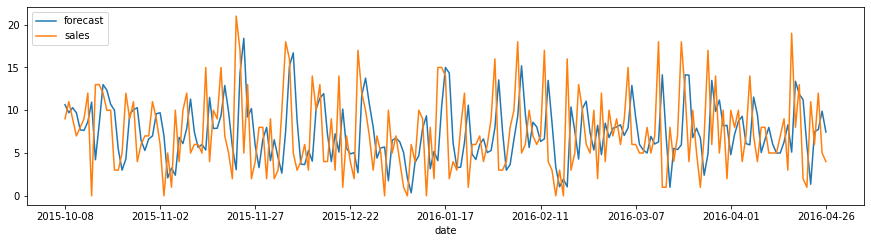

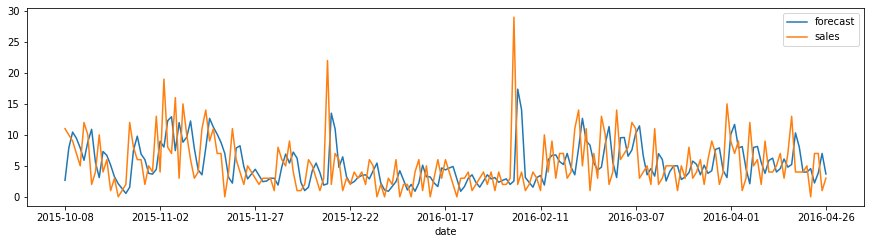

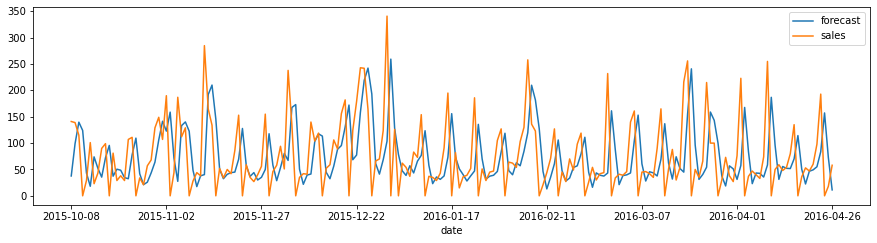

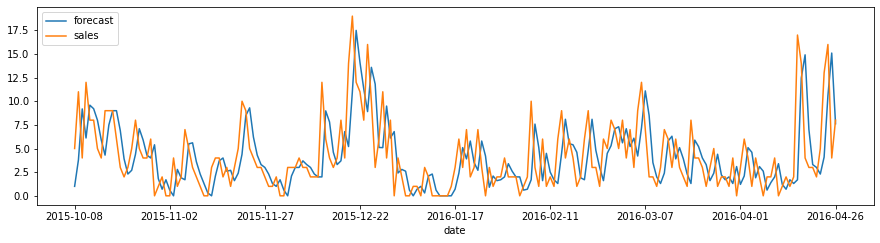

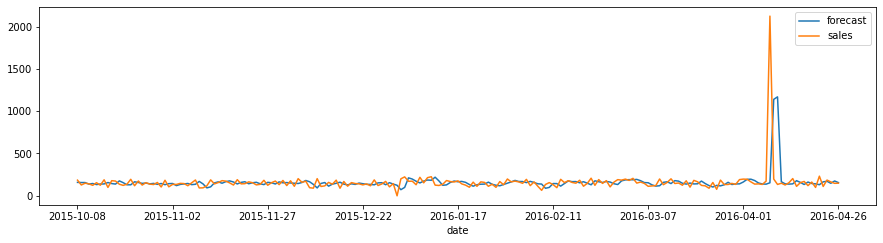

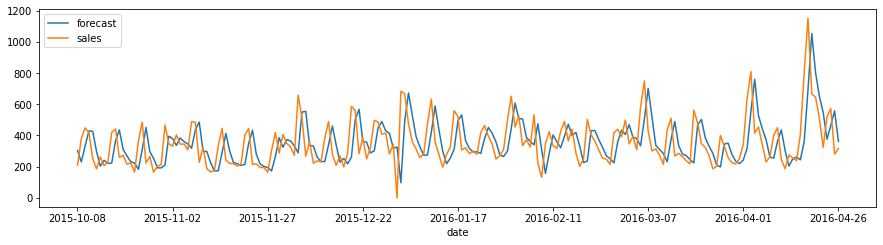

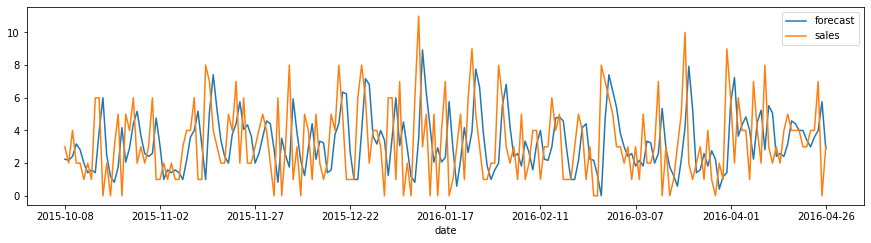

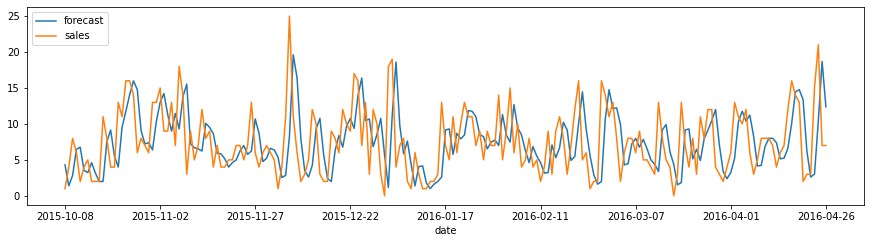

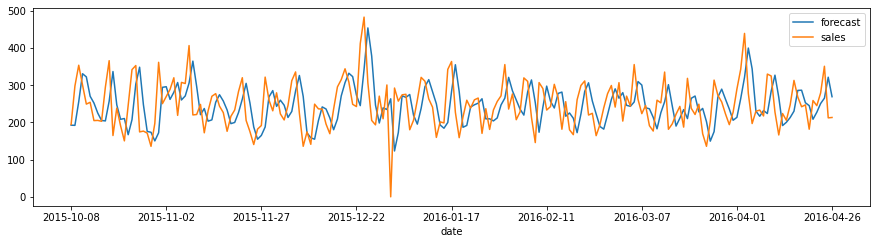

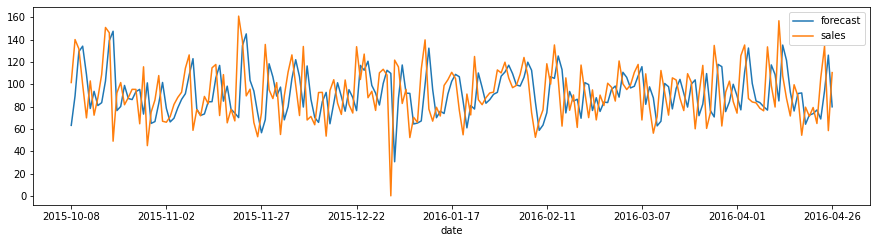

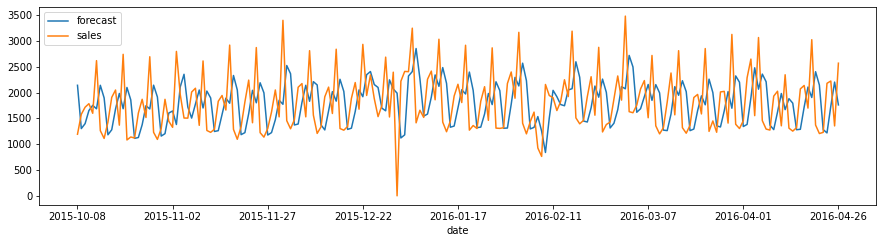

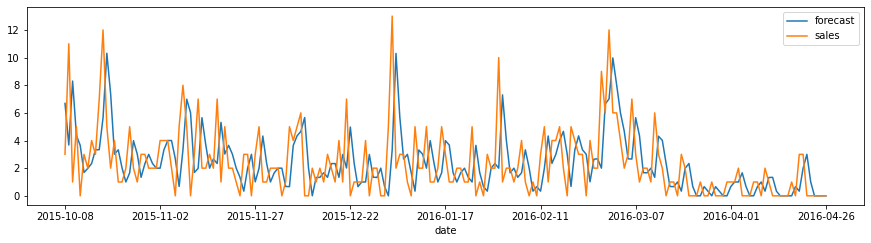

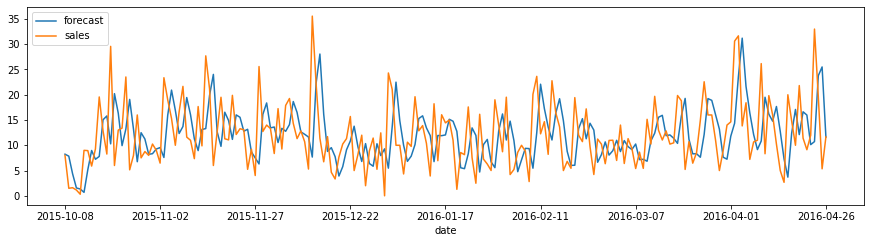

In [40]:
#deriving the rmsle and models for each family
for fam in unique['family_unique'] :
    rmsle_value = train_model(fam, train_df)
    #storing rmsle values in a list
    rmsle_list.append(rmsle_value)
    print("family:", fam, rmsle_value)

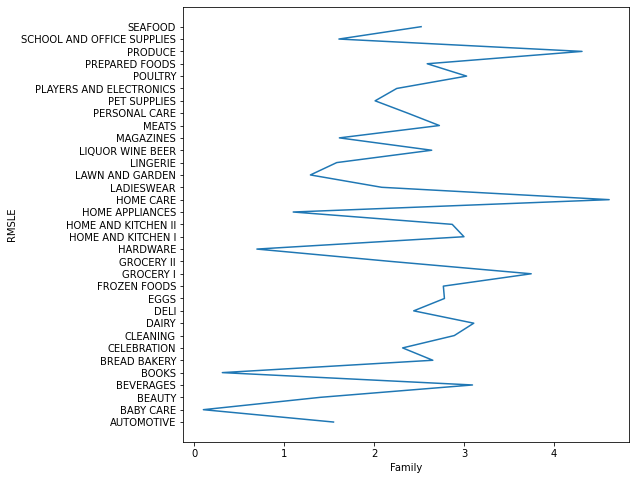

In [41]:
#plotting the rmsle values for ARIMA
plt.figure(figsize=(8,8))
plt.xlabel('Family', fontsize=10)
plt.ylabel('RMSLE', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(rmsle_list, unique['family_unique'])
plt.show()

In [42]:
#Cleaning the family names of test csv
test_df['family'] = test_df['family'].str.replace("/", " ")
test_df['family'] = test_df['family'].str.replace(",", " ")

In [43]:
#creating lists for unique values of store number and family
unique['test_strnbr_unique'] = test_df["store_nbr"].dropna().unique()
unique['test_family_unique'] = test_df["family"].dropna().unique()


In [44]:
#creating the forecast for test dataset
test_final_df = pd.DataFrame()
for i in unique['test_family_unique']:
    temp_join_df = test_df[(test_df["family"] == i)]
    temp_join_df = temp_join_df.sort_values(['store_nbr', 'date'])
    
    #reusing the created models
    model_fit = model_reuse('modelTrain_' + i + '.h5')
    #adding a forecast column
    temp_join_df['forecast'] = model_fit.forecast(steps = 864)[0]
    test_final_df = test_final_df.append(temp_join_df, ignore_index = True)


In [45]:
# test_final_df is the final dataset, saved as csv file
test_final_df.to_csv("ForeCasted_ARIMA") 